## Scattering of a plane wave by a homogeneous circle

This demo illustrates how to:
 * Compute the scattering of a plane wave by a homogeneous dielectric obstable
 * Solve the volume integral equation using an iterative method
 * Postprocess the solution to evaluate the total field
 * Check the accuracy by comparing to the analytical solution
 * Make a nice plot of the solution in the domain

In [1]:
# Import packages
import os
import sys
# FIXME: avoid this sys.path stuff
sys.path.append(os.path.join(os.path.abspath(''), '../../'))
import numpy as np
from scipy.sparse.linalg import LinearOperator, gmres
import time
from vines.geometry.geometry import shape_2d, generatedomain2d
from vines.operators.acoustic_operators import get_operator_2d, circulant_embedding
from vines.fields.plane_wave import PlaneWave_2d
from vines.operators.acoustic_matvecs import mvp_2d
from vines.precondition.circulant_acoustic import mvp_circ_2d, circulant_preconditioner
import matplotlib.pyplot as plt

In [2]:
# Set problem parameters and discretization resolution
ko = 20          # wavenumber
refInd = 1.2     # refractive index
shape = 'circle'    # choose shape (hex, circle, ellipse)
radius = 1       # radius of shape
n_per_lam = 10   # number of points per wavelength
angle = 0  # Incident wave angle to x-axis
d_inc = np.array([np.cos(angle), np.sin(angle)])

In [3]:
lambda_ext = 2 * np.pi / ko  # wavelength
# Generate grid points (r), indices of interior points (idx), pixel size (dx), 
# shape vertices (verts), interior wavelength (lambda_int)

r, idx, dx, verts, lambda_int = shape_2d(shape, refInd, lambda_ext, radius, n_per_lam)

M, N, _ = r.shape  # number of voxels in x,y directions (M, N, respectively)

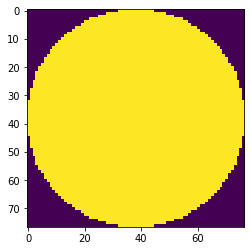

In [4]:
# Plot the "idx" variable, which indicates which pixels lie within the circular scatterer
plt.imshow(idx)
plt.show()

In [5]:
# Get Toeplitz operator
a = np.sqrt(dx**2 / np.pi)  # radius of equivalent area circle
toep = get_operator_2d(dx**2, ko, r, a)

In [6]:
# Circulant embedding of Toeplitz matrix (required for FFT matvec)
opCirc = circulant_embedding(toep, M ,N)

In [7]:
# Set up the mu^2-1 matrix, call it MR
mu_sq = np.ones((M, N))
mu_sq[idx] = refInd ** 2
MR = mu_sq - 1

In [8]:
# Define matrix-vector product and corresponding linear operator
mvp = lambda x: mvp_2d(x, opCirc, idx, MR)

A = LinearOperator((M*N, M*N), matvec=mvp)

In [9]:
# Construct circulant approximation of Toeplitz matrix in x-direction
start = time.time()
circ_inv = circulant_preconditioner(toep, M, N, refInd)
end = time.time()
print('Preconditioner assembly time = ', end - start)

Preconditioner assembly time =  0.03997492790222168


In [10]:
# Set up matrix-vector product with circulant preconditioner and establish preconditioner operator
mvp_prec = lambda x: mvp_circ_2d(x, circ_inv, M, N, idx)
prec = LinearOperator((M*N, M*N), matvec=mvp_prec)

In [11]:
# Assemble right-hand side (u_inc). Use a plane wave.
u_inc = PlaneWave_2d(1, ko, d_inc, r)

# Create an array that equals the incident field inside the scatterer and is zero outside
rhs = np.zeros((M, N), dtype=np.complex128)
rhs[idx] = u_inc[idx]
rhs_vec = rhs.reshape((M*N, 1), order='F')

In [12]:
# Perform iterative solve
it_count = 0

def iteration_counter(x):
    global it_count
    it_count += 1

start = time.time()
solp, info = gmres(A, rhs_vec, M=prec, tol=1e-5, callback=iteration_counter)
end = time.time()
print("The linear system was solved in {0} iterations".format(it_count))
print("Solve time {0} seconds".format(end-start))

The linear system was solved in 30 iterations
Solve time 0.1520700454711914 seconds


In [13]:
from vines.operators.acoustic_matvecs import scattered_field
# Scattered field
u_sca = scattered_field(solp, opCirc, M, N, MR)
# Total field
u = u_inc + u_sca

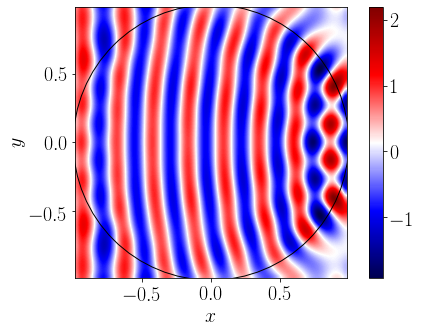

In [14]:
# Plot the field
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=(8, 5))
ax = fig.gca()
plt.imshow(np.real(u.T), extent=[r[0, 0, 0], r[-1, 0, 0], r[0, 0, 1], r[0, -1, 1]],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16')

circle = plt.Circle((0., 0.), radius, color='black', fill=False)
ax.add_artist(circle)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()
plt.show()

In [16]:
# Compare with analytical solution
from analytical.analytical import penetrable_circle
u_exact = penetrable_circle(ko, ko*refInd, radius, r.T)

In [17]:
# Compute the error (transposes are required due to different defintions of coordinates shape)
error_l2 = np.linalg.norm(u_exact.T - u) / np.linalg.norm(u_exact.T)
print('error = ', error_l2)

error =  0.020115714560849308
